In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# 1. Eksik ve hatalı değerleri temizleme
data = pd.read_csv("/content/sample_data/csv_building_structure.csv")  # Verinizin bulunduğu dosya

# Kullanılacak sütunlar
# numerical_columns = ["latitude", "longitude", "age", "plinth_area_sq_ft", "height_ft_pre_eq"]
numerical_columns = ["age_building", "plinth_area_sq_ft", "height_ft_pre_eq"]
# categorical_columns = [
#    "land_surface_condition", "foundation_type", "ground_floor_type", "roof_type",
#    "superstructure_type", "plan_configuration", "position"
#]

categorical_columns = [
    "land_surface_condition", "foundation_type", "ground_floor_type", "roof_type",
    "plan_configuration", "position"
]
target_damage = 'damage_grade'  # Hasar derecesi hedefi
target_rehabilitation = 'technical_solution_proposed'  # Rehabilitasyon hedefi

In [27]:
data = data.dropna(subset=['technical_solution_proposed'])

data['technical_solution_proposed'] = data['technical_solution_proposed'].replace(['Major repair', 'Minor repair'], 'Repair')

# Belirtilen sütunlar ve hedef değişkenler dışındaki sütunları çıkarma
data = data[numerical_columns + categorical_columns + [target_damage, target_rehabilitation]]

# Kategorik sütunlardaki eksik ve hatalı verileri temizleme
data[categorical_columns] = data[categorical_columns].apply(lambda x: x.str.lower().str.strip())
data.fillna('unknown', inplace=True)  # Eksik değerleri 'unknown' ile doldur

# 2. Hedef ve girdi değişkenlerini belirleme
features = numerical_columns + categorical_columns

# Kategorik verileri OneHotEncode etme
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(data[categorical_columns])
onehot_columns = encoder.get_feature_names_out(categorical_columns)

# Sayısal ve kategorik değişkenleri birleştirme
final_data = pd.concat([
    data[numerical_columns].reset_index(drop=True),
    pd.DataFrame(encoded_features, columns=onehot_columns).reset_index(drop=True)
], axis=1)

<ipython-input-27-fbb49ab150f0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['technical_solution_proposed'] = data['technical_solution_proposed'].replace(['Major repair', 'Minor repair'], 'Repair')


In [28]:
# 3. Hedef değişkenleri sayısala çevirme
label_encoder = LabelEncoder()
Y_damage = label_encoder.fit_transform(data[target_damage])
Y_rehabilitation = label_encoder.fit_transform(data[target_rehabilitation])

# 4. SMOTE ile sınıf dengesini sağlama
smote = SMOTE(random_state=42)
X_damage_balanced, Y_damage_balanced = smote.fit_resample(final_data, Y_damage)
X_rehabilitation_balanced, Y_rehabilitation_balanced = smote.fit_resample(final_data, Y_rehabilitation)

# 5. Eğitim ve test verisi bölme
X_train_damage, X_test_damage, Y_train_damage, Y_test_damage = train_test_split(
    X_damage_balanced, Y_damage_balanced, test_size=0.33, random_state=42
)
X_train_rehab, X_test_rehab, Y_train_rehab, Y_test_rehab = train_test_split(
    X_rehabilitation_balanced, Y_rehabilitation_balanced, test_size=0.33, random_state=42
)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validatio


Decision Tree modeli sonuçları:
Hasar Derecesi Tahmini:
              precision    recall  f1-score   support

           0       0.62      0.65      0.63     91080
           1       0.46      0.49      0.47     90866
           2       0.39      0.41      0.40     91183
           3       0.39      0.38      0.38     91196
           4       0.46      0.39      0.42     90689

    accuracy                           0.46    455014
   macro avg       0.46      0.46      0.46    455014
weighted avg       0.46      0.46      0.46    455014

Doğruluk: 0.46284949474082115
Rehabilitasyon Müdahalesi Tahmini:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82    155322
           1       0.69      0.71      0.70    154861
           2       0.60      0.55      0.58    155334

    accuracy                           0.70    465517
   macro avg       0.70      0.70      0.70    465517
weighted avg       0.70      0.70      0.70    465517

Doğruluk

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Hasar Derecesi Tahmini:
              precision    recall  f1-score   support

           0       0.53      0.62      0.58     91080
           1       0.28      0.14      0.19     90866
           2       0.24      0.12      0.16     91183
           3       0.27      0.37      0.32     91196
           4       0.31      0.45      0.37     90689

    accuracy                           0.34    455014
   macro avg       0.33      0.34      0.32    455014
weighted avg       0.33      0.34      0.32    455014

Doğruluk: 0.34186420637606757


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Rehabilitasyon Müdahalesi Tahmini:
              precision    recall  f1-score   support

           0       0.68      0.67      0.67    155322
           1       0.52      0.89      0.66    154861
           2       0.38      0.12      0.18    155334

    accuracy                           0.56    465517
   macro avg       0.53      0.56      0.51    465517
weighted avg       0.53      0.56      0.50    465517

Doğruluk: 0.5586777711662517


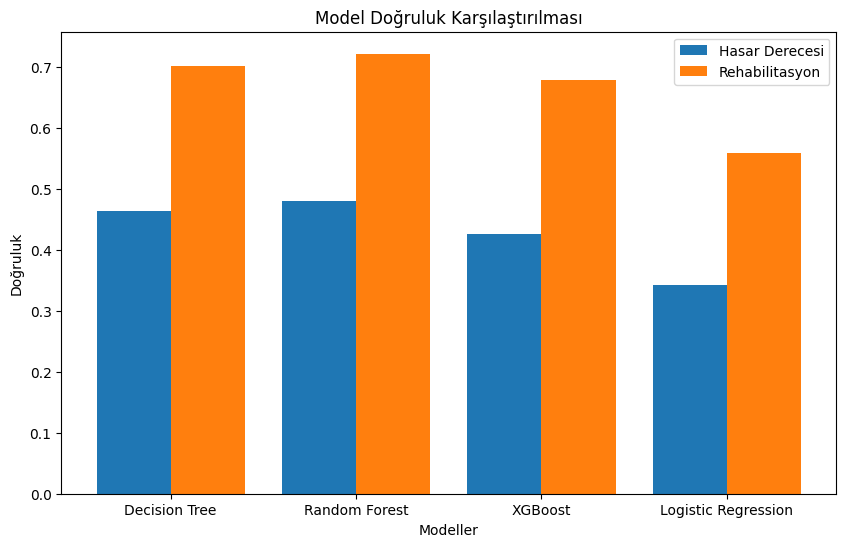

In [25]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000) # max_iter arttırıldı
}

accuracy_results = {}

for model_name, model in models.items():
    print(f"\n{model_name} modeli sonuçları:")

    # Hasar Derecesi Tahmini
    model.fit(X_train_damage, Y_train_damage)
    Y_pred_damage = model.predict(X_test_damage)
    accuracy_damage = accuracy_score(Y_test_damage, Y_pred_damage)
    print("Hasar Derecesi Tahmini:")
    print(classification_report(Y_test_damage, Y_pred_damage))
    print("Doğruluk:", accuracy_damage)


    # Rehabilitasyon Müdahalesi Tahmini
    model.fit(X_train_rehab, Y_train_rehab)
    Y_pred_rehab = model.predict(X_test_rehab)
    accuracy_rehab = accuracy_score(Y_test_rehab, Y_pred_rehab)
    print("Rehabilitasyon Müdahalesi Tahmini:")
    print(classification_report(Y_test_rehab, Y_pred_rehab))
    print("Doğruluk:", accuracy_rehab)

    accuracy_results[model_name] = {"damage": accuracy_damage, "rehab": accuracy_rehab}


# Grafik oluşturma
plt.figure(figsize=(10, 6))
models_names = list(accuracy_results.keys())
damage_accuracies = [accuracy_results[model]["damage"] for model in models_names]
rehab_accuracies = [accuracy_results[model]["rehab"] for model in models_names]
X_axis = np.arange(len(models_names))

plt.bar(X_axis - 0.2, damage_accuracies, 0.4, label='Hasar Derecesi')
plt.bar(X_axis + 0.2, rehab_accuracies, 0.4, label='Rehabilitasyon')

plt.xticks(X_axis, models_names)
plt.xlabel("Modeller")
plt.ylabel("Doğruluk")
plt.title("Model Doğruluk Karşılaştırılması")
plt.legend()
plt.show()